In [35]:
import csv
import numpy as np
import pandas as pd
# import seaborn as sns
# import sklearn

col_dtypes = {'Overall': np.int32, 'Age': np.int32}
df = pd.read_csv('Complete/CompleteDataset.csv', usecols=['Name', 'Photo', 'Value', 'Overall', 'Age', 'Finishing'], dtype=col_dtypes, low_memory=False)

df['Value'] = df['Value'].str.replace('€','')

#parse string for millions and thousands to numeric values
def parseValue(strVal):
    if 'M' in strVal:
        return int(float(strVal.replace('M', '')) * 1000000)
    elif 'K' in strVal:
        return int(float(strVal.replace('K', '')) * 1000)
    else:
        return int(strVal)   
 
df['Value'] = df['Value'].apply(lambda x: parseValue(x))

#check if there are null/missing values and how many in each column
# df.isnull().sum()

#Nobody can have a value lower or equal than zero, so those values are bad entries and we need to remove them
df = df.loc[df.Value > 0]

def between_1_and_99(s):
    try:
        n = int(s)
        return (1 <= n and n <= 99)
    except ValueError:
        return False
 
# remove not valid entries for Finishing
df = df.loc[df['Finishing'].apply(lambda x: between_1_and_99(x))]
 
# now we can define Finishing as integers
df['Finishing'] = df['Finishing'].astype('int')

# df.count
df.head(3)
# df.Value.describe()
# df.nlargest(5, columns='Overall')
# df.nlargest(5, columns='Overall')

,Name,Age,Photo,Overall,Value,Finishing
0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,94,95500000,94
1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,93,105000000,95
2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,92,123000000,89


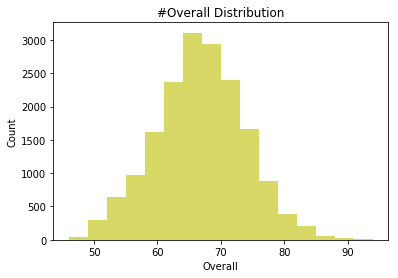

In [36]:
import matplotlib.pyplot as plt

plt.hist(df.Overall, bins=16, alpha=0.6, color='y')
plt.title("#Overall Distribution")
plt.xlabel("Overall")
plt.ylabel("Count")

plt.show()

In [37]:
overall_mean = df.Overall.mean()
overall_std = df.Overall.std()
print('The mean value for the Overall feature is ', overall_mean, ' and the standard deviation is ', overall_std)

The mean value for the Overall feature is  66.22917494747601  and the standard deviation is  7.003240305890887


In [38]:
#number of observations in +/-1 std, +/- 2std and +/- 3 std
std1_count = (df[(df.Overall >= (overall_mean - 1*overall_std)) & (df.Overall <= overall_mean + 1*overall_std)]['Overall']).count()
std2_count = (df[(df.Overall >= (overall_mean - 2*overall_std)) & (df.Overall <= overall_mean + 2*overall_std)]['Overall']).count()
std3_count = (df[(df.Overall >= (overall_mean - 3*overall_std)) & (df.Overall <= overall_mean + 3*overall_std)]['Overall']).count()

#% of observations in each range
overall_total_count = df.Overall.count()
percentage_std1 = std1_count/overall_total_count * 100 #empirically it should be 68% approx
percentage_std2 = std2_count/overall_total_count * 100 #empirically it should be 95% approx
percentage_std3 = std3_count/overall_total_count * 100 #empirically it should be 99.7% approx

print('1 std % : ', percentage_std1, ', 2 std % : ', percentage_std2, ', 3 std % : ', percentage_std3)

1 std % :  68.951223667 , 2 std % :  94.9236272784 , 3 std % :  99.8126171143


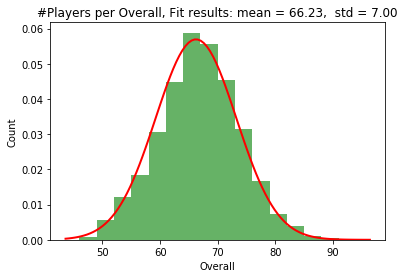

In [39]:
from scipy.stats import norm

#plot the histogram
plt.hist(df.Overall, bins=16, normed=True, alpha=0.6, color='g')
plt.title("#Players per Overall")
plt.xlabel("Overall")
plt.ylabel("Count")

# Plot the probability density function for norm
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, overall_mean, overall_std)
plt.plot(x, p, 'k', linewidth=2, color='r')
title = "#Players per Overall, Fit results: mean = %.2f,  std = %.2f" % (overall_mean, overall_std)
plt.title(title)

plt.show()

In [42]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.20, random_state=99)

xtrain = train[['Value']]
ytrain = train[['Overall']]

xtest = test[['Value']]
ytest = test[['Overall']]

# Create linear regression object
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(xtrain, ytrain)b

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [56]:
print(df.Value.min(numeric_only=None))
print(df.Value.max(numeric_only=None))
print(df.Overall.min(numeric_only=None))
print(df.Overall.max(numeric_only=None))

10000
123000000
46
94


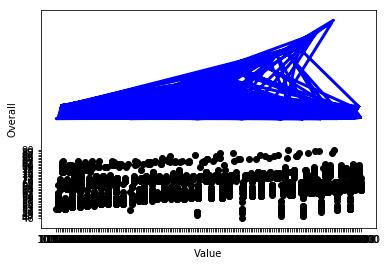

In [59]:
# Make predictions using the testing set
y_pred = regr.predict(xtest)

plt.scatter(xtest, ytest,  color='black')
plt.plot(xtest, y_pred, color='blue', linewidth=3)
plt.xlabel("Value")
plt.ylabel("Overall")
plt.show()

In [60]:
print('% of players with a value lower that €30M: ', df[df.Value <= 30000000].Value.count() / df.Value.count() * 100, '%')

% of players with a value lower that €30M:  99.3299642269 %


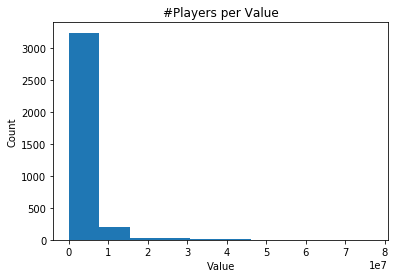

In [61]:
plt.hist(test.Value)
plt.title("#Players per Value")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()

In [63]:
import numpy as np # Linear algebra
from sklearn.metrics import mean_squared_error, r2_score #common metris to evaluate regression models

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(ytest, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(ytest, y_pred))

Mean squared error: 28.88
Variance score: 0.41


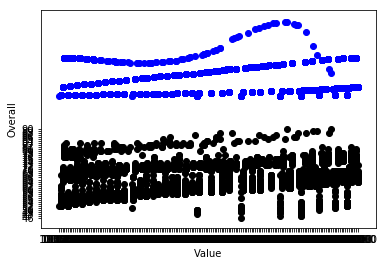

In [64]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pol = make_pipeline(PolynomialFeatures(6), linear_model.Ridge())
pol.fit(xtrain, ytrain)

y_pol = pol.predict(xtest)
plt.scatter(xtest, ytest,  color='black')
plt.scatter(xtest, y_pol,  color='blue')
plt.xlabel("Value")
plt.ylabel("Overall")
plt.show()

In [65]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(ytest, y_pol))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(ytest, y_pol))

Mean squared error: 13.07
Variance score: 0.73


In [66]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel='rbf', gamma=1e-3, C=100, epsilon=0.1)
svr_rbf.fit(xtrain, ytrain.values.ravel())

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [67]:
y_rbf = svr_rbf.predict(xtest)

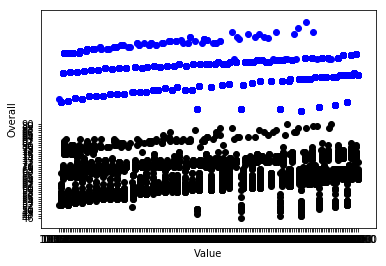

In [68]:
plt.scatter(xtest, ytest,  color='black')
plt.scatter(xtest, y_rbf,  color='blue')
plt.xlabel("Value")
plt.ylabel("Overall")
plt.show()

In [69]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(ytest, y_rbf))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(ytest, y_rbf))

Mean squared error: 6.00
Variance score: 0.88


In [70]:
xtrain = train[['Value', 'Age', 'Finishing']]
xtest = test[['Value', 'Age', 'Finishing']]
xtrain.head()

,Value,Age,Finishing
1141,12000000,23,76
13167,650000,19,55
17890,60000,18,43
5393,1400000,29,27
8268,550000,30,41


In [71]:
regr_more_features = linear_model.LinearRegression()
regr_more_features.fit(xtrain, ytrain)
y_pred_more_features = regr_more_features.predict(xtest)
print("Mean squared error: %.2f" % mean_squared_error(ytest, y_pred_more_features))
print('Variance score: %.2f' % r2_score(ytest, y_pred_more_features))

Mean squared error: 20.19
Variance score: 0.59


In [72]:
pol_more_features = make_pipeline(PolynomialFeatures(4), linear_model.Ridge())
pol_more_features.fit(xtrain, ytrain)
y_pol_more_features = pol_more_features.predict(xtest)
print("Mean squared error: %.2f" % mean_squared_error(ytest, y_pol_more_features))
print('Variance score: %.2f' % r2_score(ytest, y_pol_more_features))

Mean squared error: 8.32
Variance score: 0.83


In [73]:
svr_rbf_more_features = SVR(kernel='rbf', gamma=1e-3, C=100, epsilon=0.1)
svr_rbf_more_features.fit(xtrain, ytrain.values.ravel())
y_rbf_more_features = svr_rbf_more_features.predict(xtest)
print("Mean squared error: %.2f" % mean_squared_error(ytest, y_rbf_more_features))
print('Variance score: %.2f' % r2_score(ytest, y_rbf_more_features))

Mean squared error: 1.23
Variance score: 0.97


In [74]:
pd.options.mode.chained_assignment = None
test['Overall_Prediction_RBF'] = y_rbf_more_features
test['Error_Percentage'] =  np.abs((test.Overall - y_rbf_more_features) / test.Overall * 100)

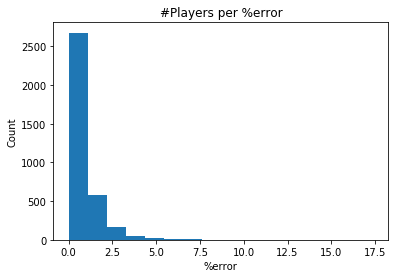

In [75]:
test[['Name', 'Age', 'Value', 'Overall', 'Overall_Prediction_RBF','Error_Percentage']].nlargest(15, columns='Error_Percentage')
plt.hist(test.Error_Percentage, bins=16)
plt.title("#Players per %error")
plt.xlabel("%error")
plt.ylabel("Count")
plt.show()

In [76]:
y_rbf_all = svr_rbf_more_features.predict(df[['Value', 'Age', 'Finishing']])
print("Mean squared error: %.2f" % mean_squared_error(df[['Overall']], y_rbf_all))
print('Variance score: %.2f' % r2_score(df[['Overall']], y_rbf_all))

Mean squared error: 0.61
Variance score: 0.99


In [78]:
#from IPython.html import widgets

pd.options.mode.chained_assignment = None
df['Overall_Prediction_RBF'] = y_rbf_all
df['Error_Percentage'] =  np.abs((df.Overall - y_rbf_all) / df.Overall * 100)
jsonDf = df.to_json(orient='records')
#widgets.HTML(value = ''' players = ''' + jsonDf)

# https://www.uruit.com/blog/2018/02/16/soccer-and-machine-learning-tutorial/